In [144]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [145]:
path_tiny = '/home/sogangori/Downloads/tiny_set/'
path_tiny_certain_train = path_tiny + 'erase_with_uncertain_dataset/train/'
path_tiny_certain_test = path_tiny + 'erase_with_uncertain_dataset/test/'

In [146]:
#path_tiny_annotation = path_tiny + 'annotations/tiny_set_train.json'
path_tiny_annotation = path_tiny + 'annotations/tiny_set_train_with_dense.json'
path_tiny_annotation

'/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train_with_dense.json'

In [147]:
#os.path.isfile('/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train.json')
os.path.isfile(path_tiny_annotation)

True

In [148]:
with open(path_tiny_annotation, 'r') as j:
    contents = json.loads(j.read())                    

In [149]:
#contents

In [150]:
len(contents), contents.keys()

(4, dict_keys(['type', 'annotations', 'images', 'categories']))

In [151]:
images = contents['images']
annotations = contents['annotations']
print(len(images), type(images), images[:2])
print(len(annotations), type(annotations), annotations[0])

794 <class 'list'> [{'file_name': 'labeled_images/bb_V0032_I0001640.jpg', 'height': 720, 'width': 1280, 'id': 0}, {'file_name': 'labeled_images/bb_V0014_I0002600.jpg', 'height': 1080, 'width': 1920, 'id': 1}]
42197 <class 'list'> {'segmentation': [[1081.124389319407, 17.45930926910859, 1267.431666947439, 17.45930926910859, 1267.431666947439, 67.73270164492683, 1081.124389319407, 67.73270164492683]], 'bbox': [1081.124389319407, 17.45930926910859, 186.3072776280319, 50.27339237581825], 'category_id': 1, 'area': 9366.298870664552, 'iscrowd': 0, 'image_id': 0, 'id': 0, 'ignore': True, 'uncertain': False, 'logo': True, 'in_dense_image': False}


In [152]:
file_name_id_dict = dict()
for image in images:
    file_name = image['file_name']
    id_num = image['id']
    target = 'dense'
    #target = 'labeled'
    if target in file_name:
        file_name_id_dict[file_name] = id_num

In [153]:
id_values = file_name_id_dict.values()
len(id_values), len(set(id_values)), min(id_values), max(id_values)

(48, 48, 717, 764)

In [154]:
id_bbox_dict = dict()
for annotation in annotations:    
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    ignore = annotation['ignore']
    uncertain = annotation['uncertain']
        
    bbox = np.array(bbox, dtype=np.int)
    x, y, w, h = bbox
    
    if True:
        margin = 2
        x -= margin
        y -= margin
        h += margin * 2
        w += margin * 2
    bbox = [y, x, y+h, x+w]
    #print('bbox', bbox)
    #break
    
    if ignore:
        #print(image_id, bbox, ignore, uncertain)
        pass
    else:
        if image_id in id_bbox_dict.keys():
            id_bbox_dict[image_id].extend(bbox)
        else:
            id_bbox_dict[image_id] = bbox

In [155]:
np.array(id_bbox_dict[1]).reshape([-1, 4]).shape

(82, 4)

In [156]:
path_tiny_certain_train, path_tiny_certain_test

('/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/train/',
 '/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/test/')

In [157]:
input_list_train = []
bbox_list_train = []
for file_name in file_name_id_dict.keys():
    file_full_path_train = path_tiny_certain_train + file_name
    file_full_path_test = path_tiny_certain_test + file_name
    
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 4])
        
    if os.path.isfile(file_full_path_train):
        img = Image.open(file_full_path_train)
        img_arr = np.array(img)
                
        h, w, c = img_arr.shape
        scale = np.array((h, w, h, w))
        scale = np.reshape(scale, (1, 4))
        bbox_norm = bboxes_2d.astype(np.float) / scale.astype(np.float)
        cls = np.ones_like(bbox_norm[:, :1])
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)
        
        input_list_train.append(img_arr)
        bbox_list_train.append(cls_bbox_norm)        
        if len(input_list_train)%100==0:
            print('reading image', len(file_name_id_dict.keys()), len(input_list_train))
        elif os.path.isfile(file_full_path_test):        
            continue
        
print('input_list_train', len(input_list_train))

input_list_train 48


In [158]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 3] - boxes[:, 1]
    boxes_height = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        y1, x1, y2, x2 = box        
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
    plt.show()
    return ax

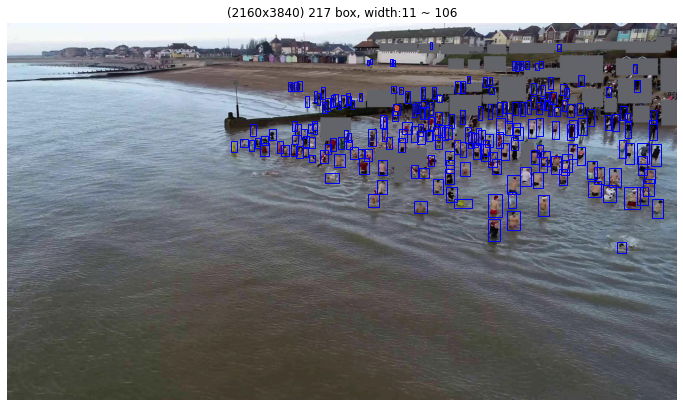

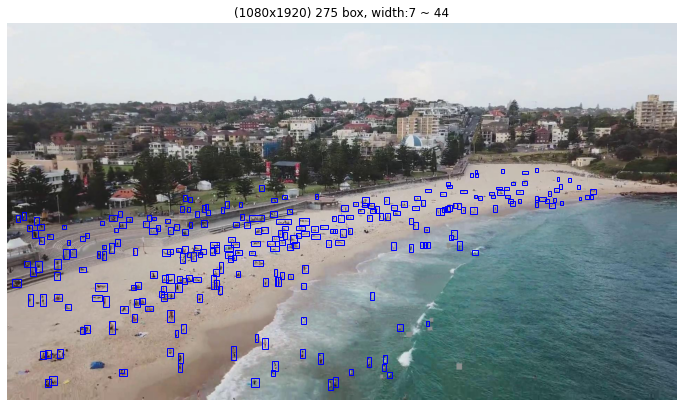

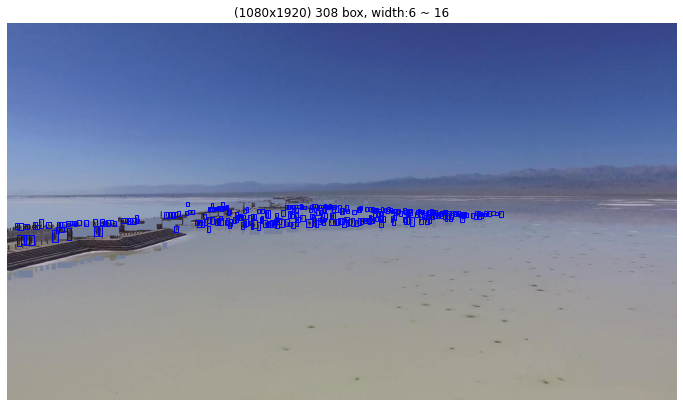

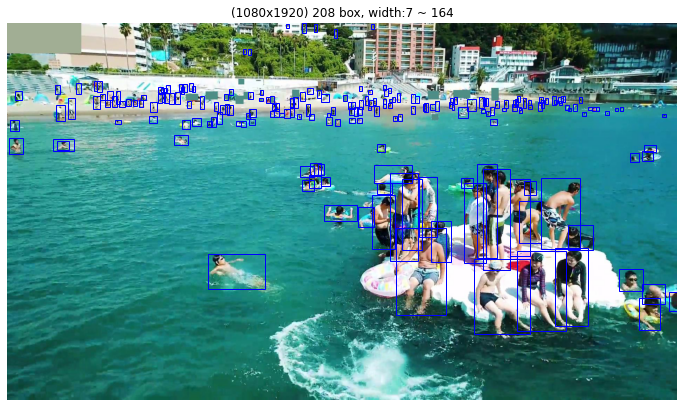

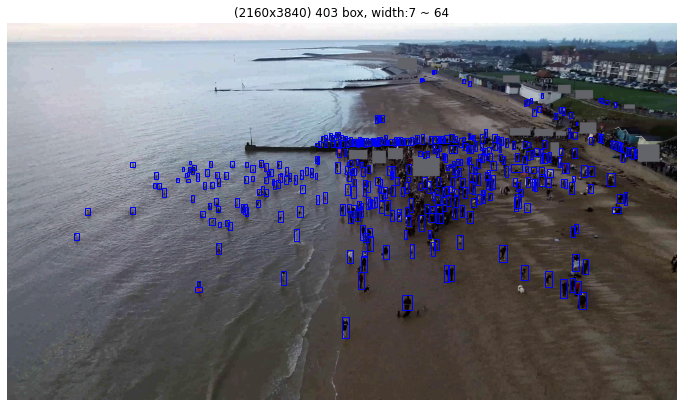

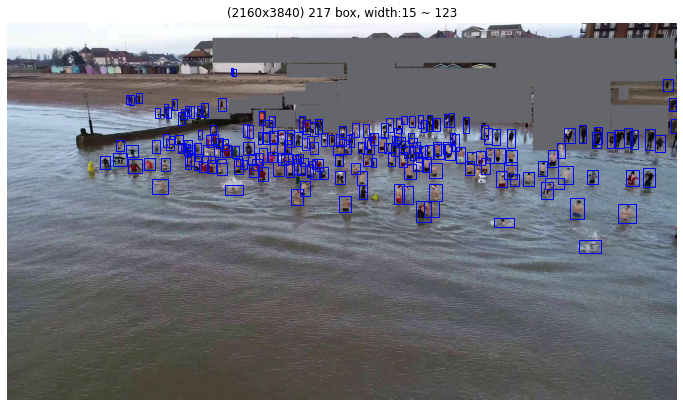

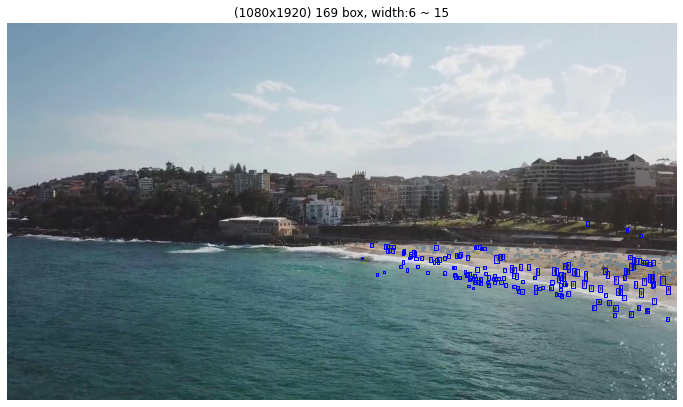

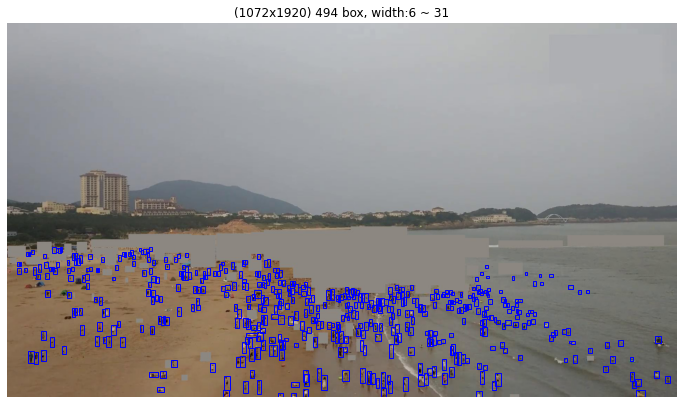

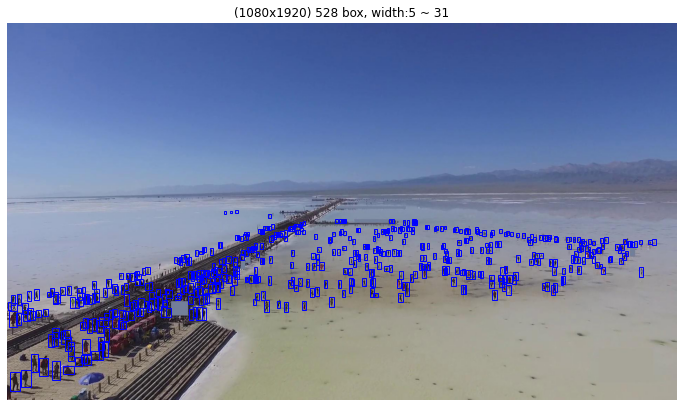

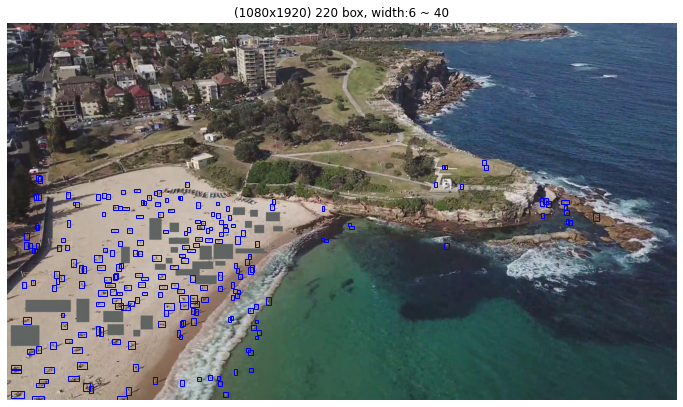

In [159]:

for i in range(10):
    img_arr = input_list_train[i]
    sample_box = bbox_list_train[i]
    label = np.ones_like(sample_box[:, 0])
    bbox = sample_box[:, 1:]

    h, w, c = img_arr.shape
    scale = np.array((h, w, h, w))
    scale = np.reshape(scale, (1, 4))
    bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
    #print('bbox_norm', bbox, bbox_norm)
    ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [160]:
WATER_CLASSES = ['bg', 'human']
num_classes = len(WATER_CLASSES)

In [161]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""


def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(10, 10), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        #text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
    plt.show()
    return ax


"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""


class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        #self.aspect_ratios = [0.5, 1.0, 2.0]        
        #self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        self.aspect_ratios = [1.0]        
        self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        #self._strides = [2 ** i for i in range(3, 8)]
        #self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._strides = [2 ** i for i in range(3, 7)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 7)
        ]
        return tf.concat(anchors, axis=0)


"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""


def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*7, 128*9], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    #image = sample["image"]
    #bbox = swap_xy(sample["objects"]["bbox"])
    #class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)
    #image = sample[0]
    #cls_bbox = sample[1]
    
    bbox = swap_xy(cls_bbox[:, 1:])
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""


class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.
        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.
        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.
        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        #batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        batch_images = tf.cast(batch_images, tf.float32)# / 255.0
        return batch_images, labels.stack()

In [162]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def relu(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)    
    return relu

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation='relu',
               padding="same")(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu(out)
    return out

def create_resnet_backbone():
    
    inputs = Input(shape=(None, None, 3))
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation='relu',
               padding="same")(inputs)
    t = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 5, 5, 2]
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
    #t = AveragePooling2D(4)(t)
    #t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    #8, 16, 32, 64, 128
    model = Model(inputs, t_list)
    
    return model

In [163]:
"""
## Building the ResNet50 backbone
RetinaNet uses a ResNet based backbone, using which a feature pyramid network
is constructed. In the example we use ResNet50 as the backbone, and return the
feature maps at strides 8, 16 and 32.
"""

"""
## Building Feature Pyramid Network as a custom layer
"""

class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else create_resnet_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        #self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)
        self.dropout = keras.layers.Dropout(.1)#20.8.8

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        c3_output = self.dropout(c3_output)#20.8.8
        c4_output = self.dropout(c4_output)#20.8.8
        c5_output = self.dropout(c5_output)#20.8.8
        p3_output = self.conv_c3_1x1(c3_output)#err
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        #p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        #8, 16, 32, 64, 128
        return p3_output, p4_output, p5_output, p6_output#, p7_output


"""
## Building the classification and box regression heads.
The RetinaNet model has separate heads for bounding box regression and
for predicting class probabilities for the objects. These heads are shared
between all the feature maps of the feature pyramid.
"""


def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.
    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.
    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(output_filters, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init, )
    )
    return head


"""
## Building RetinaNet using a subclassed model
"""

def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, anchor_k, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        #backbone = get_backbone()        
        backbone = create_resnet_backbone()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        #anchor 9 = 3*3
        #anchor_k = 1*1
        self.cls_head = build_head(anchor_k * num_classes, prior_probability)
        self.box_head = build_head(anchor_k * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:            
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


"""
## Implementing a custom layer to decode predictions
"""


class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.
    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=num_classes,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=1000,
        max_detections=1000,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


"""
## Implementing Smooth L1 loss and Focal Loss as keras custom losses
"""


class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        loss = tf.reduce_sum(loss, axis=-1)
        return loss
    

class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # return tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss
 

In [164]:
#Metric
def recall(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)
    h_cls = y_pred[:, :, 4:]
    y_cls_hot = tf.one_hot(y_cls_symbol, depth=num_classes)
    
    h_cls_symbol = tf.argmax(h_cls, axis=-1, output_type=tf.int32)
    true_positives = tf.logical_and(tf.equal(y_cls_symbol, h_cls_symbol), y_cls_symbol>0)
    true_positives = tf.reduce_sum(tf.cast(true_positives, tf.float32), axis=1)
    possible_positives = tf.reduce_sum(tf.cast(y_cls_symbol > 0, tf.float32), axis=1)    
    rec = tf.reduce_mean(true_positives / (possible_positives + 1e-8))    
    
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)
    h_cls = y_pred[:, :, 4:]
    
    y_cls_hot = tf.one_hot(y_cls_symbol, depth=num_classes)    
    h_cls_symbol = tf.argmax(h_cls, axis=-1, output_type=tf.int32)
    
    true_positives = tf.logical_and(tf.equal(y_cls_symbol, h_cls_symbol), y_cls_symbol>0)
    true_positives = tf.reduce_sum(tf.cast(true_positives, tf.float32), axis=1)
    predicted_positives = tf.reduce_sum(tf.cast(h_cls_symbol > 0, tf.float32), axis=1)    
    prec = tf.reduce_mean(true_positives / (predicted_positives + 1e-8))
    return prec


In [165]:
len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

1

In [166]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
model_dir = "retinanet/rect_anchor"
label_encoder = LabelEncoder()

loss_fn = RetinaNetLoss(num_classes)
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)
model = RetinaNet(num_classes, anchor_k)

optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[recall, precision])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_dir,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
    )
]

In [182]:
def load_weight():   
    weights_dir = model_dir#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [183]:
def generator():
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset
np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]    
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (2160, 3840, 3) (217, 5) [1.   0.15 0.43 0.18 0.44]


cls_bbox [[1.   0.15 0.43 0.18 0.44]
 [1.   0.16 0.43 0.18 0.43]
 [1.   0.16 0.42 0.18 0.43]
 ...
 [1.   0.21 0.75 0.24 0.76]
 [1.   0.2  0.8  0.23 0.8 ]
 [1.   0.1  0.79 0.12 0.8 ]]


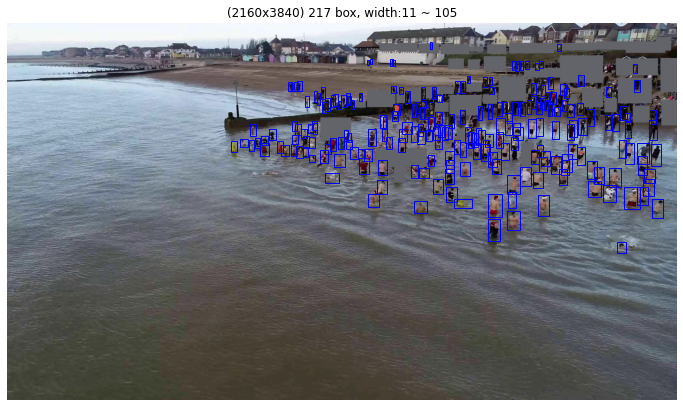

In [184]:
for example in tfds.as_numpy(dataset):
    #print(example[0].shape, example[1].shape)
    
    image = tf.cast(example[0], dtype=tf.float32)
    cls_bbox = example[1]        
    print('cls_bbox', cls_bbox)
    
    label = tf.cast(cls_bbox[:, 0],dtype=tf.int32)
    bbox = cls_bbox[:, 1:]
    h, w, c = image.shape    
    bbox_ori = bbox * np.array((h,w,h,w)).reshape((1, 4))
    #print('bbox_ori', bbox_ori)
    
    visualize_detections_simple(image,bbox_ori,label)
    break

In [185]:
batch_size = 3 #6 OOM
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = dataset_test.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

In [186]:
loss_list = []
recall_list = []
load_weight()
print(len(input_list_train))

latest_checkpoint retinanet/rect_anchor
48


In [114]:
epochs = 100000
hist = model.fit(
    train_dataset.take(100),
    validation_data=None,
    epochs=epochs,
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)

Epoch 1/100000
16/16 [==============================] - 8s 517ms/step - loss: 1.6234 - recall: 0.7500 - precision: 0.0023
Epoch 2/100000
16/16 [==============================] - 9s 536ms/step - loss: 1.7077 - recall: 0.8121 - precision: 0.0025
Epoch 3/100000
16/16 [==============================] - 9s 540ms/step - loss: 1.7417 - recall: 0.8121 - precision: 0.0027
Epoch 4/100000
16/16 [==============================] - 10s 616ms/step - loss: 1.6727 - recall: 0.7707 - precision: 0.0023
Epoch 5/100000
16/16 [==============================] - 8s 513ms/step - loss: 1.7260 - recall: 0.8122 - precision: 0.0027
Epoch 6/100000
16/16 [==============================] - 8s 517ms/step - loss: 1.6178 - recall: 0.7708 - precision: 0.0021
Epoch 7/100000
16/16 [==============================] - 8s 530ms/step - loss: 1.6583 - recall: 0.7912 - precision: 0.0027
Epoch 8/100000
16/16 [==============================] - 8s 515ms/step - loss: 1.6410 - recall: 0.7706 - precision: 0.0023
Epoch 9/100000
16/16 [=

16/16 [==============================] - 8s 516ms/step - loss: 1.4154 - recall: 0.7290 - precision: 0.0024
Epoch 68/100000
16/16 [==============================] - 8s 496ms/step - loss: 1.4726 - recall: 0.7496 - precision: 0.0030
Epoch 69/100000
16/16 [==============================] - 8s 502ms/step - loss: 1.4216 - recall: 0.7708 - precision: 0.0023
Epoch 70/100000
16/16 [==============================] - 8s 504ms/step - loss: 1.4965 - recall: 0.7708 - precision: 0.0025
Epoch 71/100000
16/16 [==============================] - 8s 505ms/step - loss: 1.5035 - recall: 0.7915 - precision: 0.0023
Epoch 72/100000
16/16 [==============================] - 8s 513ms/step - loss: 1.4555 - recall: 0.7708 - precision: 0.0025
Epoch 73/100000
16/16 [==============================] - 9s 536ms/step - loss: 1.6588 - recall: 0.7495 - precision: 0.0037
Epoch 74/100000
16/16 [==============================] - 8s 517ms/step - loss: 1.5444 - recall: 0.7707 - precision: 0.0024
Epoch 75/100000
16/16 [=========

16/16 [==============================] - 8s 526ms/step - loss: 1.6324 - recall: 0.7903 - precision: 0.0039
Epoch 134/100000
16/16 [==============================] - 8s 500ms/step - loss: 1.4674 - recall: 0.7917 - precision: 0.0021
Epoch 135/100000
16/16 [==============================] - 8s 507ms/step - loss: 1.4148 - recall: 0.7708 - precision: 0.0024
Epoch 136/100000
16/16 [==============================] - 8s 519ms/step - loss: 1.4027 - recall: 0.7917 - precision: 0.0026
Epoch 137/100000
16/16 [==============================] - 8s 503ms/step - loss: 1.3963 - recall: 0.8118 - precision: 0.0034
Epoch 138/100000
16/16 [==============================] - 10s 601ms/step - loss: 1.4326 - recall: 0.7912 - precision: 0.0034
Epoch 139/100000
16/16 [==============================] - 8s 530ms/step - loss: 1.3830 - recall: 0.7705 - precision: 0.0030
Epoch 140/100000
16/16 [==============================] - 8s 494ms/step - loss: 1.3813 - recall: 0.7916 - precision: 0.0024
Epoch 141/100000
16/16 [

16/16 [==============================] - 9s 545ms/step - loss: 1.2213 - recall: 0.7707 - precision: 0.0027
Epoch 200/100000
16/16 [==============================] - 8s 518ms/step - loss: 1.2604 - recall: 0.7916 - precision: 0.0029
Epoch 201/100000
16/16 [==============================] - 8s 518ms/step - loss: 1.1863 - recall: 0.7499 - precision: 0.0028
Epoch 202/100000
16/16 [==============================] - 11s 657ms/step - loss: 1.2683 - recall: 0.7707 - precision: 0.0032
Epoch 203/100000
16/16 [==============================] - 8s 515ms/step - loss: 1.2634 - recall: 0.7917 - precision: 0.0026
Epoch 204/100000
16/16 [==============================] - 9s 580ms/step - loss: 1.2127 - recall: 0.8124 - precision: 0.0030
Epoch 205/100000
16/16 [==============================] - 8s 506ms/step - loss: 1.3052 - recall: 0.8328 - precision: 0.0036
Epoch 206/100000
16/16 [==============================] - 8s 491ms/step - loss: 1.2266 - recall: 0.8125 - precision: 0.0029
Epoch 207/100000
16/16 [

16/16 [==============================] - 9s 554ms/step - loss: 1.1325 - recall: 0.8124 - precision: 0.0035
Epoch 266/100000
16/16 [==============================] - 9s 542ms/step - loss: 1.0927 - recall: 0.7917 - precision: 0.0025
Epoch 267/100000
16/16 [==============================] - 8s 518ms/step - loss: 1.0959 - recall: 0.7916 - precision: 0.0027
Epoch 268/100000
16/16 [==============================] - 10s 603ms/step - loss: 1.0417 - recall: 0.7917 - precision: 0.0027
Epoch 269/100000
16/16 [==============================] - 9s 542ms/step - loss: 1.1140 - recall: 0.8123 - precision: 0.0034
Epoch 270/100000
16/16 [==============================] - 8s 513ms/step - loss: 1.0498 - recall: 0.7498 - precision: 0.0031
Epoch 271/100000
16/16 [==============================] - 8s 523ms/step - loss: 1.0995 - recall: 0.8333 - precision: 0.0026
Epoch 272/100000
16/16 [==============================] - 8s 507ms/step - loss: 1.0705 - recall: 0.8124 - precision: 0.0029
Epoch 273/100000
16/16 [

16/16 [==============================] - 8s 516ms/step - loss: 0.9128 - recall: 0.7292 - precision: 0.0031
Epoch 332/100000
16/16 [==============================] - 8s 488ms/step - loss: 0.9547 - recall: 0.7497 - precision: 0.0033
Epoch 333/100000
16/16 [==============================] - 8s 505ms/step - loss: 0.9396 - recall: 0.7917 - precision: 0.0033
Epoch 334/100000
16/16 [==============================] - 9s 551ms/step - loss: 0.9383 - recall: 0.8125 - precision: 0.0034
Epoch 335/100000
16/16 [==============================] - 8s 506ms/step - loss: 0.9286 - recall: 0.7917 - precision: 0.0028
Epoch 336/100000
16/16 [==============================] - 8s 499ms/step - loss: 1.0373 - recall: 0.8541 - precision: 0.0032
Epoch 337/100000
16/16 [==============================] - 8s 510ms/step - loss: 1.0560 - recall: 0.7909 - precision: 0.0045
Epoch 338/100000
16/16 [==============================] - 8s 521ms/step - loss: 1.5464 - recall: 0.7889 - precision: 0.0047
Epoch 339/100000
16/16 [=

16/16 [==============================] - 8s 492ms/step - loss: 0.8989 - recall: 0.8120 - precision: 0.0036
Epoch 398/100000
16/16 [==============================] - 8s 518ms/step - loss: 0.8982 - recall: 0.7707 - precision: 0.0037
Epoch 399/100000
16/16 [==============================] - 9s 548ms/step - loss: 0.9149 - recall: 0.8125 - precision: 0.0032
Epoch 400/100000
16/16 [==============================] - 9s 559ms/step - loss: 0.8412 - recall: 0.7915 - precision: 0.0036
Epoch 401/100000
16/16 [==============================] - 8s 518ms/step - loss: 0.8922 - recall: 0.8125 - precision: 0.0035
Epoch 402/100000
16/16 [==============================] - 10s 608ms/step - loss: 0.8612 - recall: 0.7914 - precision: 0.0033
Epoch 403/100000
16/16 [==============================] - 8s 496ms/step - loss: 0.8392 - recall: 0.7917 - precision: 0.0033
Epoch 404/100000
16/16 [==============================] - 8s 514ms/step - loss: 0.8233 - recall: 0.7499 - precision: 0.0033
Epoch 405/100000
16/16 [

16/16 [==============================] - 8s 510ms/step - loss: 0.8029 - recall: 0.7290 - precision: 0.0037
Epoch 464/100000
16/16 [==============================] - 8s 495ms/step - loss: 0.8046 - recall: 0.8124 - precision: 0.0033
Epoch 465/100000
16/16 [==============================] - 8s 507ms/step - loss: 0.8422 - recall: 0.8333 - precision: 0.0035
Epoch 466/100000
16/16 [==============================] - 8s 519ms/step - loss: 0.8075 - recall: 0.8125 - precision: 0.0036
Epoch 467/100000
16/16 [==============================] - 8s 512ms/step - loss: 0.7744 - recall: 0.7913 - precision: 0.0036
Epoch 468/100000
16/16 [==============================] - 9s 549ms/step - loss: 0.7851 - recall: 0.7917 - precision: 0.0027
Epoch 469/100000
16/16 [==============================] - 8s 516ms/step - loss: 0.7725 - recall: 0.7500 - precision: 0.0036
Epoch 470/100000
16/16 [==============================] - 8s 513ms/step - loss: 0.8076 - recall: 0.8124 - precision: 0.0030
Epoch 471/100000
16/16 [=

16/16 [==============================] - 9s 560ms/step - loss: 0.6624 - recall: 0.8125 - precision: 0.0033
Epoch 530/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.7700 - recall: 0.8125 - precision: 0.0039
Epoch 531/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.7075 - recall: 0.7915 - precision: 0.0035
Epoch 532/100000
16/16 [==============================] - 8s 528ms/step - loss: 0.6770 - recall: 0.7917 - precision: 0.0029
Epoch 533/100000
16/16 [==============================] - 8s 505ms/step - loss: 0.7220 - recall: 0.8332 - precision: 0.0032
Epoch 534/100000
16/16 [==============================] - 8s 489ms/step - loss: 0.7114 - recall: 0.8124 - precision: 0.0037
Epoch 535/100000
16/16 [==============================] - 8s 525ms/step - loss: 0.6871 - recall: 0.7708 - precision: 0.0037
Epoch 536/100000
16/16 [==============================] - 8s 516ms/step - loss: 0.7006 - recall: 0.8124 - precision: 0.0037
Epoch 537/100000
16/16 [=

16/16 [==============================] - 8s 510ms/step - loss: 0.6475 - recall: 0.8124 - precision: 0.0032
Epoch 596/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.7085 - recall: 0.8125 - precision: 0.0033
Epoch 597/100000
16/16 [==============================] - 8s 504ms/step - loss: 0.6938 - recall: 0.7915 - precision: 0.0032
Epoch 598/100000
16/16 [==============================] - 10s 598ms/step - loss: 0.6621 - recall: 0.7917 - precision: 0.0028
Epoch 599/100000
16/16 [==============================] - 9s 555ms/step - loss: 0.7126 - recall: 0.7706 - precision: 0.0036
Epoch 600/100000
16/16 [==============================] - 8s 499ms/step - loss: 0.6892 - recall: 0.7917 - precision: 0.0030
Epoch 601/100000
16/16 [==============================] - 8s 520ms/step - loss: 0.6673 - recall: 0.8125 - precision: 0.0028
Epoch 602/100000
16/16 [==============================] - 9s 547ms/step - loss: 0.6503 - recall: 0.7916 - precision: 0.0034
Epoch 603/100000
16/16 [

16/16 [==============================] - 8s 490ms/step - loss: 0.5963 - recall: 0.7916 - precision: 0.0035
Epoch 662/100000
16/16 [==============================] - 8s 503ms/step - loss: 0.6001 - recall: 0.7917 - precision: 0.0027
Epoch 663/100000
16/16 [==============================] - 9s 545ms/step - loss: 0.6091 - recall: 0.7707 - precision: 0.0035
Epoch 664/100000
16/16 [==============================] - 8s 509ms/step - loss: 0.6036 - recall: 0.8122 - precision: 0.0035
Epoch 665/100000
16/16 [==============================] - 10s 614ms/step - loss: 0.6065 - recall: 0.7915 - precision: 0.0033
Epoch 666/100000
16/16 [==============================] - 8s 475ms/step - loss: 0.5758 - recall: 0.7917 - precision: 0.0041
Epoch 667/100000
16/16 [==============================] - 8s 490ms/step - loss: 0.5839 - recall: 0.8125 - precision: 0.0036
Epoch 668/100000
16/16 [==============================] - 9s 578ms/step - loss: 0.6152 - recall: 0.7917 - precision: 0.0036
Epoch 669/100000
16/16 [

16/16 [==============================] - 8s 527ms/step - loss: 0.5430 - recall: 0.7917 - precision: 0.0031
Epoch 728/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.5784 - recall: 0.7708 - precision: 0.0029
Epoch 729/100000
16/16 [==============================] - 9s 531ms/step - loss: 0.5776 - recall: 0.7917 - precision: 0.0035
Epoch 730/100000
16/16 [==============================] - 12s 731ms/step - loss: 0.5116 - recall: 0.7708 - precision: 0.0037
Epoch 731/100000
16/16 [==============================] - 8s 510ms/step - loss: 0.5568 - recall: 0.7917 - precision: 0.0029
Epoch 732/100000
16/16 [==============================] - 10s 604ms/step - loss: 0.5551 - recall: 0.7708 - precision: 0.0028
Epoch 733/100000
16/16 [==============================] - 8s 498ms/step - loss: 0.5607 - recall: 0.7499 - precision: 0.0031
Epoch 734/100000
16/16 [==============================] - 8s 495ms/step - loss: 0.5451 - recall: 0.7500 - precision: 0.0029
Epoch 735/100000
16/16 

16/16 [==============================] - 9s 539ms/step - loss: 0.4950 - recall: 0.7917 - precision: 0.0035
Epoch 794/100000
16/16 [==============================] - 8s 493ms/step - loss: 0.5516 - recall: 0.8333 - precision: 0.0038
Epoch 795/100000
16/16 [==============================] - 8s 512ms/step - loss: 0.5271 - recall: 0.7706 - precision: 0.0040
Epoch 796/100000
16/16 [==============================] - 8s 515ms/step - loss: 0.5230 - recall: 0.7499 - precision: 0.0035
Epoch 797/100000
16/16 [==============================] - 8s 527ms/step - loss: 0.5427 - recall: 0.8125 - precision: 0.0029
Epoch 798/100000
16/16 [==============================] - 8s 507ms/step - loss: 0.4790 - recall: 0.7916 - precision: 0.0032
Epoch 799/100000
16/16 [==============================] - 9s 548ms/step - loss: 0.4755 - recall: 0.8125 - precision: 0.0029
Epoch 800/100000
16/16 [==============================] - 8s 499ms/step - loss: 0.5608 - recall: 0.8125 - precision: 0.0034
Epoch 801/100000
16/16 [=

16/16 [==============================] - 9s 549ms/step - loss: 0.4481 - recall: 0.7917 - precision: 0.0038
Epoch 860/100000
16/16 [==============================] - 8s 494ms/step - loss: 0.4582 - recall: 0.7708 - precision: 0.0035
Epoch 861/100000
16/16 [==============================] - 8s 509ms/step - loss: 0.4625 - recall: 0.8124 - precision: 0.0040
Epoch 862/100000
16/16 [==============================] - 8s 518ms/step - loss: 0.4665 - recall: 0.8125 - precision: 0.0030
Epoch 863/100000
16/16 [==============================] - 9s 567ms/step - loss: 0.5608 - recall: 0.7708 - precision: 0.0036
Epoch 864/100000
16/16 [==============================] - 8s 486ms/step - loss: 0.4860 - recall: 0.7917 - precision: 0.0032
Epoch 865/100000
16/16 [==============================] - 12s 737ms/step - loss: 0.4601 - recall: 0.7917 - precision: 0.0033
Epoch 866/100000
16/16 [==============================] - 8s 504ms/step - loss: 0.4937 - recall: 0.7708 - precision: 0.0036
Epoch 867/100000
16/16 [

16/16 [==============================] - 8s 497ms/step - loss: 0.4569 - recall: 0.7917 - precision: 0.0040
Epoch 926/100000
16/16 [==============================] - 8s 515ms/step - loss: 0.4394 - recall: 0.7499 - precision: 0.0035
Epoch 927/100000
16/16 [==============================] - 9s 554ms/step - loss: 0.4267 - recall: 0.7708 - precision: 0.0038
Epoch 928/100000
16/16 [==============================] - 9s 573ms/step - loss: 0.4677 - recall: 0.7707 - precision: 0.0052
Epoch 929/100000
16/16 [==============================] - 9s 537ms/step - loss: 0.4303 - recall: 0.7708 - precision: 0.0039
Epoch 930/100000
16/16 [==============================] - 8s 492ms/step - loss: 0.4586 - recall: 0.8333 - precision: 0.0039
Epoch 931/100000
16/16 [==============================] - 8s 513ms/step - loss: 0.4691 - recall: 0.7917 - precision: 0.0031
Epoch 932/100000
16/16 [==============================] - 10s 634ms/step - loss: 0.4529 - recall: 0.7708 - precision: 0.0032
Epoch 933/100000
16/16 [

16/16 [==============================] - 9s 540ms/step - loss: 0.4064 - recall: 0.7500 - precision: 0.0033
Epoch 992/100000
16/16 [==============================] - 8s 513ms/step - loss: 0.3985 - recall: 0.7917 - precision: 0.0036
Epoch 993/100000
16/16 [==============================] - 8s 510ms/step - loss: 0.3984 - recall: 0.8125 - precision: 0.0033
Epoch 994/100000
16/16 [==============================] - 8s 508ms/step - loss: 0.4001 - recall: 0.7707 - precision: 0.0036
Epoch 995/100000
16/16 [==============================] - 9s 539ms/step - loss: 0.3963 - recall: 0.7500 - precision: 0.0037
Epoch 996/100000
16/16 [==============================] - 8s 487ms/step - loss: 0.3935 - recall: 0.7917 - precision: 0.0042
Epoch 997/100000
16/16 [==============================] - 12s 756ms/step - loss: 0.3869 - recall: 0.8124 - precision: 0.0041
Epoch 998/100000
16/16 [==============================] - 9s 552ms/step - loss: 0.3985 - recall: 0.7707 - precision: 0.0039
Epoch 999/100000
16/16 [

16/16 [==============================] - 8s 495ms/step - loss: 0.3793 - recall: 0.8125 - precision: 0.0034
Epoch 1057/100000
16/16 [==============================] - 8s 516ms/step - loss: 0.3812 - recall: 0.7917 - precision: 0.0031
Epoch 1058/100000
16/16 [==============================] - 8s 517ms/step - loss: 0.3925 - recall: 0.7917 - precision: 0.0034
Epoch 1059/100000
16/16 [==============================] - 9s 558ms/step - loss: 0.3619 - recall: 0.7708 - precision: 0.0036
Epoch 1060/100000
16/16 [==============================] - 9s 532ms/step - loss: 0.3563 - recall: 0.7917 - precision: 0.0032
Epoch 1061/100000
16/16 [==============================] - 8s 491ms/step - loss: 0.3508 - recall: 0.7917 - precision: 0.0036
Epoch 1062/100000
16/16 [==============================] - 9s 537ms/step - loss: 0.3759 - recall: 0.7500 - precision: 0.0034
Epoch 1063/100000
16/16 [==============================] - 9s 564ms/step - loss: 0.4124 - recall: 0.8125 - precision: 0.0046
Epoch 1064/100000


16/16 [==============================] - 8s 508ms/step - loss: 0.4080 - recall: 0.7707 - precision: 0.0037
Epoch 1122/100000
16/16 [==============================] - 8s 488ms/step - loss: 0.3669 - recall: 0.7708 - precision: 0.0032
Epoch 1123/100000
16/16 [==============================] - 8s 508ms/step - loss: 0.3703 - recall: 0.8125 - precision: 0.0033
Epoch 1124/100000
16/16 [==============================] - 9s 539ms/step - loss: 0.3507 - recall: 0.8125 - precision: 0.0038
Epoch 1125/100000
16/16 [==============================] - 8s 515ms/step - loss: 0.3371 - recall: 0.7916 - precision: 0.0038
Epoch 1126/100000
16/16 [==============================] - 13s 844ms/step - loss: 0.3310 - recall: 0.7917 - precision: 0.0040
Epoch 1127/100000
16/16 [==============================] - 8s 496ms/step - loss: 0.3804 - recall: 0.7917 - precision: 0.0035
Epoch 1128/100000
16/16 [==============================] - 9s 532ms/step - loss: 0.3630 - recall: 0.8125 - precision: 0.0034
Epoch 1129/100000

16/16 [==============================] - 8s 486ms/step - loss: 0.3550 - recall: 0.7708 - precision: 0.0041
Epoch 1187/100000
16/16 [==============================] - 9s 591ms/step - loss: 0.3244 - recall: 0.7708 - precision: 0.0041
Epoch 1188/100000
16/16 [==============================] - 8s 515ms/step - loss: 0.3376 - recall: 0.7708 - precision: 0.0042
Epoch 1189/100000
16/16 [==============================] - 8s 509ms/step - loss: 0.3278 - recall: 0.7500 - precision: 0.0036
Epoch 1190/100000
16/16 [==============================] - 8s 512ms/step - loss: 0.3339 - recall: 0.7708 - precision: 0.0039
Epoch 1191/100000
16/16 [==============================] - 9s 558ms/step - loss: 0.3603 - recall: 0.7917 - precision: 0.0036
Epoch 1192/100000
16/16 [==============================] - 8s 529ms/step - loss: 0.3259 - recall: 0.8125 - precision: 0.0045
Epoch 1193/100000
16/16 [==============================] - 10s 635ms/step - loss: 0.3463 - recall: 0.7708 - precision: 0.0037
Epoch 1194/100000

16/16 [==============================] - 8s 530ms/step - loss: 0.3134 - recall: 0.7708 - precision: 0.0035
Epoch 1252/100000
16/16 [==============================] - 12s 731ms/step - loss: 0.3242 - recall: 0.7917 - precision: 0.0038
Epoch 1253/100000
16/16 [==============================] - 8s 517ms/step - loss: 0.3193 - recall: 0.7917 - precision: 0.0038
Epoch 1254/100000
16/16 [==============================] - 9s 551ms/step - loss: 0.3379 - recall: 0.7917 - precision: 0.0039
Epoch 1255/100000
16/16 [==============================] - 8s 503ms/step - loss: 0.3095 - recall: 0.7917 - precision: 0.0035
Epoch 1256/100000
16/16 [==============================] - 8s 503ms/step - loss: 0.3356 - recall: 0.8124 - precision: 0.0034
Epoch 1257/100000
16/16 [==============================] - 9s 582ms/step - loss: 0.3399 - recall: 0.8333 - precision: 0.0045
Epoch 1258/100000
16/16 [==============================] - 8s 525ms/step - loss: 0.3302 - recall: 0.7917 - precision: 0.0037
Epoch 1259/100000

16/16 [==============================] - 8s 510ms/step - loss: 0.2843 - recall: 0.7917 - precision: 0.0035
Epoch 1317/100000
16/16 [==============================] - 8s 515ms/step - loss: 0.3017 - recall: 0.7917 - precision: 0.0034
Epoch 1318/100000
16/16 [==============================] - 8s 514ms/step - loss: 0.2769 - recall: 0.8125 - precision: 0.0038
Epoch 1319/100000
16/16 [==============================] - 9s 535ms/step - loss: 0.3034 - recall: 0.8125 - precision: 0.0034
Epoch 1320/100000
16/16 [==============================] - 8s 528ms/step - loss: 0.3086 - recall: 0.7707 - precision: 0.0035
Epoch 1321/100000
16/16 [==============================] - 8s 505ms/step - loss: 0.3039 - recall: 0.7708 - precision: 0.0037
Epoch 1322/100000
16/16 [==============================] - 8s 500ms/step - loss: 0.3439 - recall: 0.8125 - precision: 0.0037
Epoch 1323/100000
16/16 [==============================] - 8s 505ms/step - loss: 0.3287 - recall: 0.7915 - precision: 0.0035
Epoch 1324/100000


16/16 [==============================] - 8s 509ms/step - loss: 0.3206 - recall: 0.8125 - precision: 0.0036
Epoch 1382/100000
16/16 [==============================] - 8s 527ms/step - loss: 0.2744 - recall: 0.7708 - precision: 0.0034
Epoch 1383/100000
16/16 [==============================] - 8s 503ms/step - loss: 0.2959 - recall: 0.7917 - precision: 0.0035
Epoch 1384/100000
16/16 [==============================] - 8s 506ms/step - loss: 0.2897 - recall: 0.7917 - precision: 0.0034
Epoch 1385/100000
16/16 [==============================] - 8s 494ms/step - loss: 0.2769 - recall: 0.7708 - precision: 0.0033
Epoch 1386/100000
16/16 [==============================] - 8s 507ms/step - loss: 0.2870 - recall: 0.8125 - precision: 0.0034
Epoch 1387/100000
16/16 [==============================] - 9s 539ms/step - loss: 0.2934 - recall: 0.7708 - precision: 0.0037
Epoch 1388/100000
16/16 [==============================] - 8s 522ms/step - loss: 0.3092 - recall: 0.7915 - precision: 0.0041
Epoch 1389/100000


16/16 [==============================] - 9s 574ms/step - loss: 0.3010 - recall: 0.8125 - precision: 0.0036
Epoch 1447/100000
16/16 [==============================] - 9s 539ms/step - loss: 0.2778 - recall: 0.8125 - precision: 0.0042
Epoch 1448/100000
16/16 [==============================] - 8s 511ms/step - loss: 0.2839 - recall: 0.7915 - precision: 0.0038
Epoch 1449/100000
16/16 [==============================] - 8s 505ms/step - loss: 0.2685 - recall: 0.7917 - precision: 0.0037
Epoch 1450/100000
16/16 [==============================] - 8s 520ms/step - loss: 0.2790 - recall: 0.7708 - precision: 0.0040
Epoch 1451/100000
16/16 [==============================] - 8s 504ms/step - loss: 0.2746 - recall: 0.8333 - precision: 0.0043
Epoch 1452/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.2629 - recall: 0.7708 - precision: 0.0040
Epoch 1453/100000
16/16 [==============================] - 9s 544ms/step - loss: 0.2594 - recall: 0.8125 - precision: 0.0039
Epoch 1454/100000


16/16 [==============================] - 8s 508ms/step - loss: 0.2505 - recall: 0.7708 - precision: 0.0036
Epoch 1512/100000
16/16 [==============================] - 9s 542ms/step - loss: 0.2609 - recall: 0.7499 - precision: 0.0039
Epoch 1513/100000
16/16 [==============================] - 8s 502ms/step - loss: 0.2605 - recall: 0.7917 - precision: 0.0039
Epoch 1514/100000
16/16 [==============================] - 11s 667ms/step - loss: 0.2464 - recall: 0.7708 - precision: 0.0044
Epoch 1515/100000
16/16 [==============================] - 8s 522ms/step - loss: 0.2403 - recall: 0.7708 - precision: 0.0042
Epoch 1516/100000
16/16 [==============================] - 9s 552ms/step - loss: 0.2785 - recall: 0.8124 - precision: 0.0043
Epoch 1517/100000
16/16 [==============================] - 8s 509ms/step - loss: 0.2533 - recall: 0.8125 - precision: 0.0041
Epoch 1518/100000
16/16 [==============================] - 8s 508ms/step - loss: 0.2725 - recall: 0.7708 - precision: 0.0038
Epoch 1519/100000

16/16 [==============================] - 9s 534ms/step - loss: 0.2465 - recall: 0.7708 - precision: 0.0039
Epoch 1577/100000
16/16 [==============================] - 9s 533ms/step - loss: 0.2521 - recall: 0.7917 - precision: 0.0036
Epoch 1578/100000
16/16 [==============================] - 9s 567ms/step - loss: 0.2575 - recall: 0.8125 - precision: 0.0041
Epoch 1579/100000
16/16 [==============================] - 9s 539ms/step - loss: 0.2399 - recall: 0.7708 - precision: 0.0036
Epoch 1580/100000
16/16 [==============================] - 8s 516ms/step - loss: 0.2506 - recall: 0.7708 - precision: 0.0042
Epoch 1581/100000
16/16 [==============================] - 8s 518ms/step - loss: 0.2556 - recall: 0.8125 - precision: 0.0042
Epoch 1582/100000
16/16 [==============================] - 9s 564ms/step - loss: 0.2441 - recall: 0.7916 - precision: 0.0038
Epoch 1583/100000
16/16 [==============================] - 8s 513ms/step - loss: 0.2730 - recall: 0.7708 - precision: 0.0039
Epoch 1584/100000


16/16 [==============================] - 9s 534ms/step - loss: 0.2543 - recall: 0.7917 - precision: 0.0041
Epoch 1642/100000
16/16 [==============================] - 9s 554ms/step - loss: 0.2499 - recall: 0.7707 - precision: 0.0040
Epoch 1643/100000
16/16 [==============================] - 8s 510ms/step - loss: 0.2427 - recall: 0.7500 - precision: 0.0036
Epoch 1644/100000
16/16 [==============================] - 8s 506ms/step - loss: 0.2138 - recall: 0.7708 - precision: 0.0036
Epoch 1645/100000
16/16 [==============================] - 9s 566ms/step - loss: 0.2390 - recall: 0.8333 - precision: 0.0040
Epoch 1646/100000
16/16 [==============================] - 9s 533ms/step - loss: 0.2210 - recall: 0.7917 - precision: 0.0041
Epoch 1647/100000
16/16 [==============================] - 8s 512ms/step - loss: 0.2520 - recall: 0.7708 - precision: 0.0041
Epoch 1648/100000
16/16 [==============================] - 8s 498ms/step - loss: 0.2500 - recall: 0.7708 - precision: 0.0043
Epoch 1649/100000


16/16 [==============================] - 8s 504ms/step - loss: 0.2305 - recall: 0.8125 - precision: 0.0043
Epoch 1707/100000
16/16 [==============================] - 11s 657ms/step - loss: 0.2335 - recall: 0.8333 - precision: 0.0042
Epoch 1708/100000
16/16 [==============================] - 9s 542ms/step - loss: 0.2418 - recall: 0.7500 - precision: 0.0040
Epoch 1709/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.2119 - recall: 0.7917 - precision: 0.0034
Epoch 1710/100000
16/16 [==============================] - 9s 585ms/step - loss: 0.2196 - recall: 0.7706 - precision: 0.0038
Epoch 1711/100000
16/16 [==============================] - 8s 501ms/step - loss: 0.2408 - recall: 0.8125 - precision: 0.0040
Epoch 1712/100000
16/16 [==============================] - 8s 528ms/step - loss: 0.2313 - recall: 0.8125 - precision: 0.0040
Epoch 1713/100000
16/16 [==============================] - 10s 636ms/step - loss: 0.2310 - recall: 0.7917 - precision: 0.0039
Epoch 1714/10000

16/16 [==============================] - 9s 593ms/step - loss: 0.2166 - recall: 0.8125 - precision: 0.0038
Epoch 1772/100000
16/16 [==============================] - 8s 508ms/step - loss: 0.2203 - recall: 0.7917 - precision: 0.0039
Epoch 1773/100000
16/16 [==============================] - 9s 552ms/step - loss: 0.2309 - recall: 0.7917 - precision: 0.0035
Epoch 1774/100000
16/16 [==============================] - 9s 560ms/step - loss: 0.2307 - recall: 0.7708 - precision: 0.0035
Epoch 1775/100000
16/16 [==============================] - 8s 518ms/step - loss: 0.2086 - recall: 0.7917 - precision: 0.0038
Epoch 1776/100000
16/16 [==============================] - 8s 493ms/step - loss: 0.2363 - recall: 0.7917 - precision: 0.0038
Epoch 1777/100000
16/16 [==============================] - 8s 524ms/step - loss: 0.2450 - recall: 0.8333 - precision: 0.0041
Epoch 1778/100000
16/16 [==============================] - 8s 509ms/step - loss: 0.2291 - recall: 0.8125 - precision: 0.0040
Epoch 1779/100000


16/16 [==============================] - 8s 518ms/step - loss: 0.2230 - recall: 0.7708 - precision: 0.0041
Epoch 1837/100000
16/16 [==============================] - 8s 493ms/step - loss: 0.2017 - recall: 0.7500 - precision: 0.0040
Epoch 1838/100000
16/16 [==============================] - 12s 755ms/step - loss: 0.1936 - recall: 0.7708 - precision: 0.0042
Epoch 1839/100000
16/16 [==============================] - 8s 514ms/step - loss: 0.2057 - recall: 0.7708 - precision: 0.0036
Epoch 1840/100000
16/16 [==============================] - 8s 506ms/step - loss: 0.2000 - recall: 0.7500 - precision: 0.0037
Epoch 1841/100000
16/16 [==============================] - 8s 512ms/step - loss: 0.2242 - recall: 0.8125 - precision: 0.0039
Epoch 1842/100000
16/16 [==============================] - 8s 508ms/step - loss: 0.2117 - recall: 0.7917 - precision: 0.0044
Epoch 1843/100000
16/16 [==============================] - 8s 510ms/step - loss: 0.1926 - recall: 0.8125 - precision: 0.0040
Epoch 1844/100000

16/16 [==============================] - 8s 505ms/step - loss: 0.2328 - recall: 0.8122 - precision: 0.0042
Epoch 1902/100000
16/16 [==============================] - 8s 512ms/step - loss: 0.1869 - recall: 0.7917 - precision: 0.0041
Epoch 1903/100000
16/16 [==============================] - 8s 498ms/step - loss: 0.1899 - recall: 0.8125 - precision: 0.0037
Epoch 1904/100000
16/16 [==============================] - 8s 508ms/step - loss: 0.2372 - recall: 0.7917 - precision: 0.0043
Epoch 1905/100000
16/16 [==============================] - 9s 546ms/step - loss: 0.2150 - recall: 0.8125 - precision: 0.0038
Epoch 1906/100000
16/16 [==============================] - 8s 530ms/step - loss: 0.2071 - recall: 0.7917 - precision: 0.0040
Epoch 1907/100000
16/16 [==============================] - 8s 514ms/step - loss: 0.1980 - recall: 0.7917 - precision: 0.0040
Epoch 1908/100000
16/16 [==============================] - 11s 661ms/step - loss: 0.2170 - recall: 0.7917 - precision: 0.0039
Epoch 1909/100000

KeyboardInterrupt: 

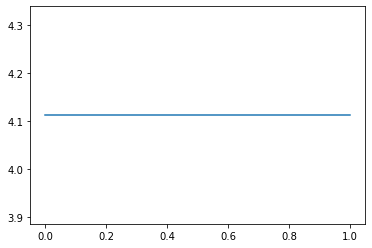

In [115]:
loss_list.extend(hist.history['loss'])
#recall_list.extend(hist.history['recall'])
plt.plot(np.array(loss_list).reshape([-1]))
#plt.plot(np.array(recall_list).reshape([-1]))

In [187]:
is_load = False
if is_load:
    weights_dir = model_dir#"data"
    latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(latest_checkpoint)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.1)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    return tf.expand_dims(image, axis=0), ratio

num_detections 285 (1, 1024, 1920, 3)


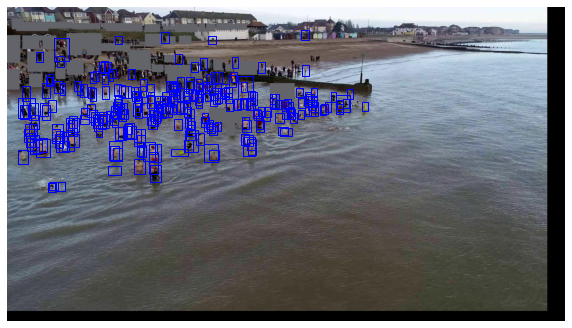

num_detections 19 (1, 1024, 1792, 3)


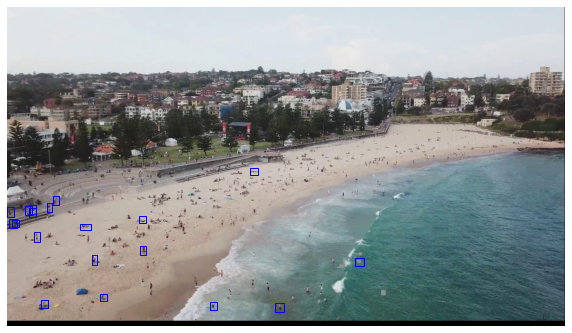

num_detections 2 (1, 1024, 1664, 3)


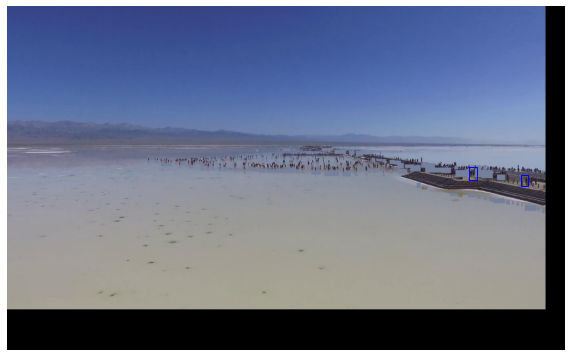

num_detections 138 (1, 1024, 1792, 3)


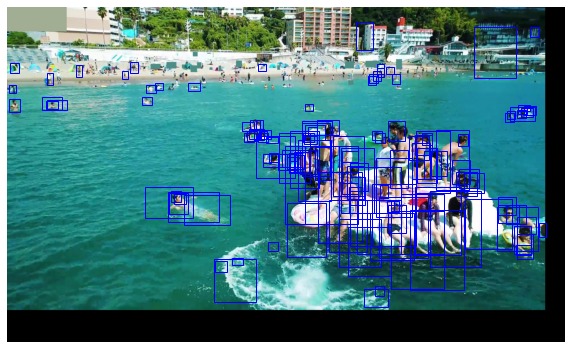

num_detections 21 (1, 1024, 1792, 3)


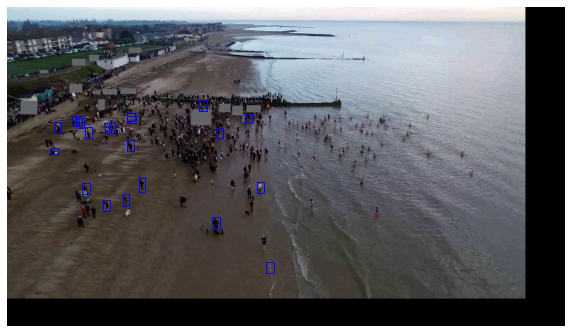

num_detections 356 (1, 1024, 1792, 3)


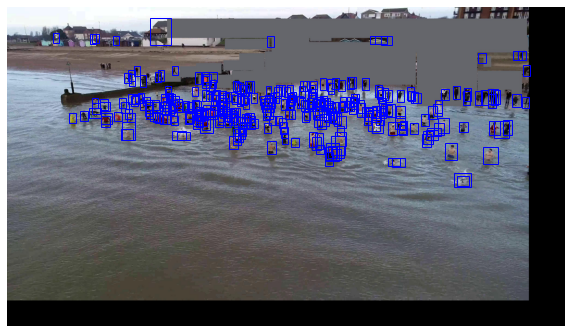

num_detections 9 (1, 1024, 1920, 3)


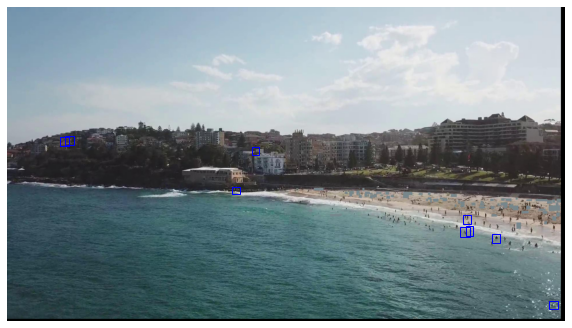

num_detections 7 (1, 1024, 1792, 3)


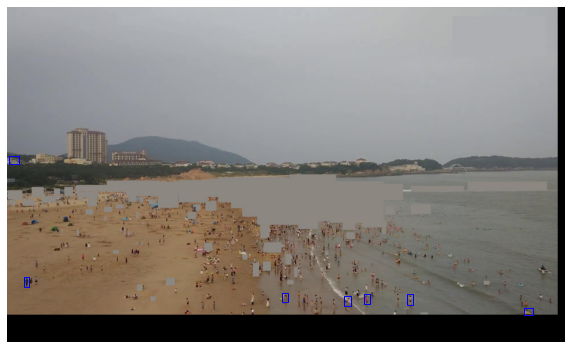

num_detections 31 (1, 1024, 1792, 3)


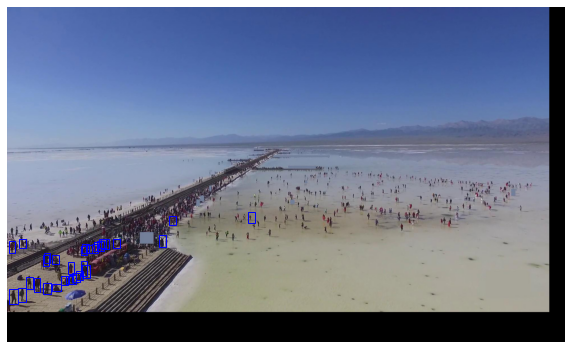

num_detections 4 (1, 1024, 1920, 3)


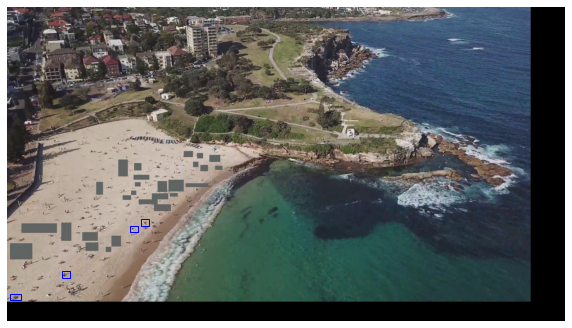

In [188]:
int2str = WATER_CLASSES
for image, cbbox in val_dataset.take(10):        
    image = image[0]      
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)        
    num_detections = detections.valid_detections[0]
    #print(detections)
    print('num_detections', num_detections, input_image.shape)
 
    class_names = [WATER_CLASSES[(int(x))] for x in detections.nmsed_classes[0][:num_detections]    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )